In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
drops_per_ms = pd.read_csv('./drops_per_2ms.csv')
B = 15000*80/9000
B

133.33333333333334

In [ ]:
drops_per_ms = pd.read_sql("""
select algorithm, action,
  5*floor(timestamp_sec*1000/5) as rounded_timestamp,
  --round(timestamp_sec::numeric, 3) as rounded_timestamp,
  num_flows,
  count(case when (was_dropped != 0) then 1 else null end) as num_dropped_packets,
  count(*) as num_packets,
  count(distinct src_port) as num_active_flows,
  count(distinct case when (was_dropped != 0) then src_port else null end) as num_dropped_flows
from postcard_traces
inner join experiments on experiments.id = postcard_traces.experiment_id
where note in ('postcard', 'postcard-ecn')
and max_queue_depth_cells = 15000
and algorithm in ('reno', 'cubic', 'bbr', 'scalable')
--and action = 'drop'
and src_port != 22
--and num_flows <= 16
group by algorithm, action, rounded_timestamp, num_flows
""", con=con)

In [24]:
drops_per_ms.to_csv('./drops_per_2ms.csv')

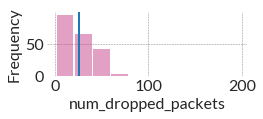

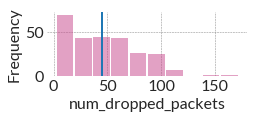

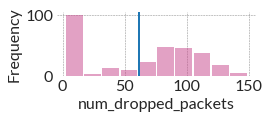

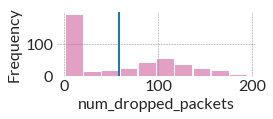

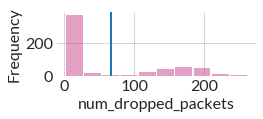

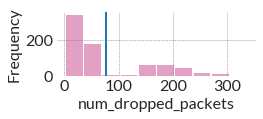

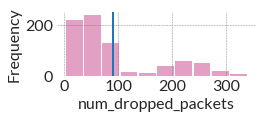

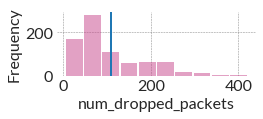

In [4]:
for num_flows, df in drops_per_ms.groupby('num_flows'):
    plt.figure()
    plorts.hist(df[df.num_dropped_flows > 0], x='num_dropped_packets')
    plt.axvline(x=np.mean(df[df.num_dropped_flows > 0].num_dropped_packets))

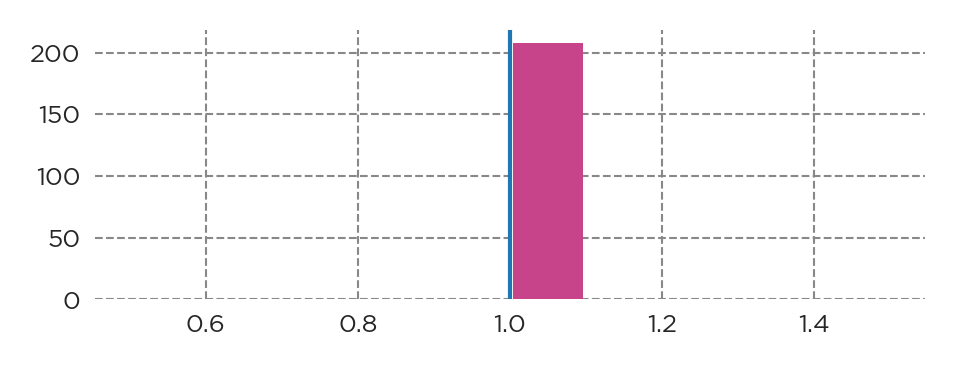

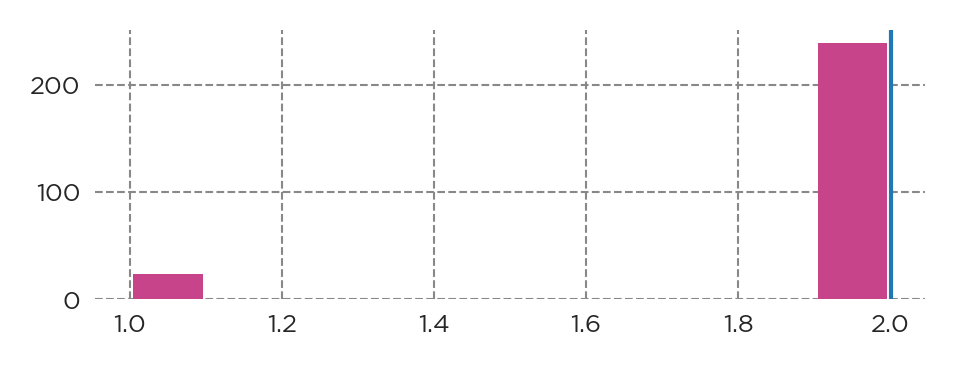

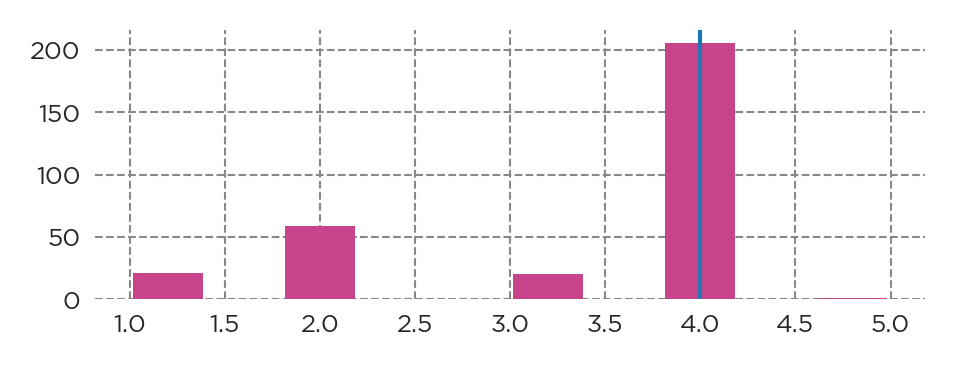

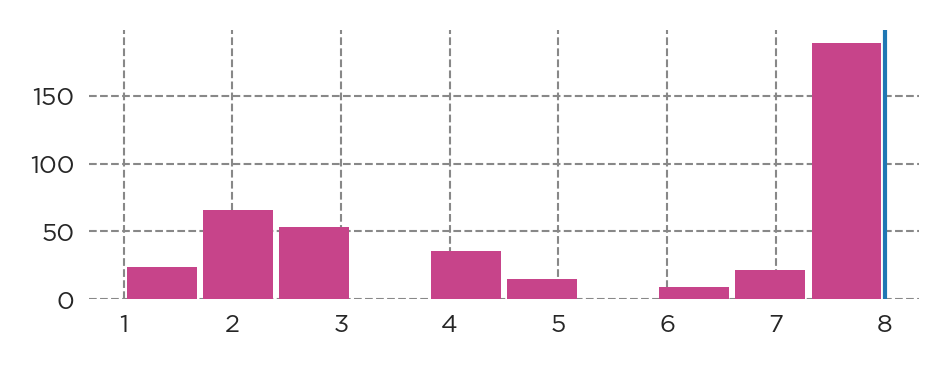

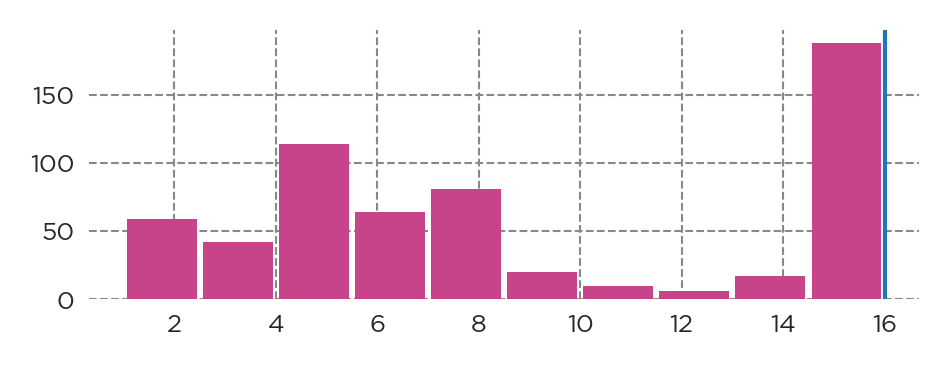

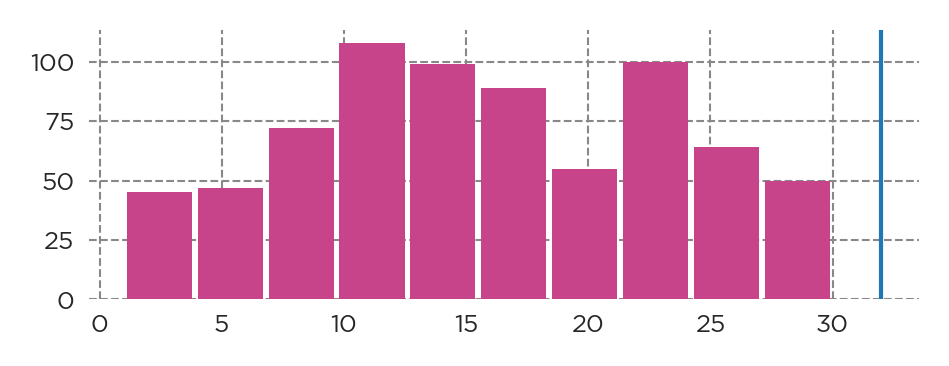

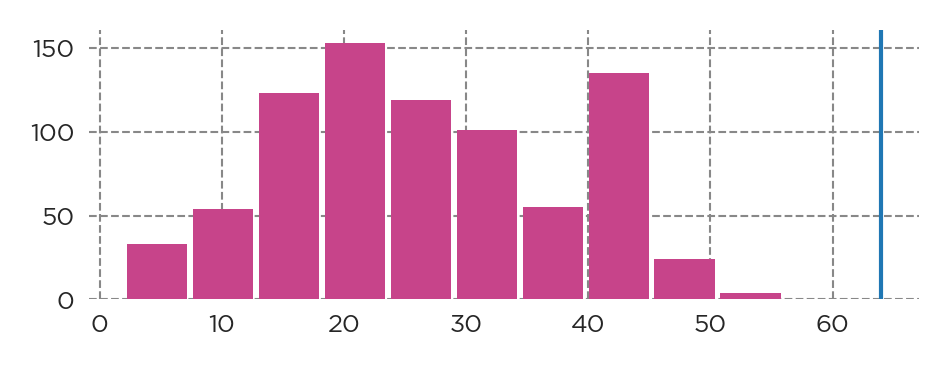

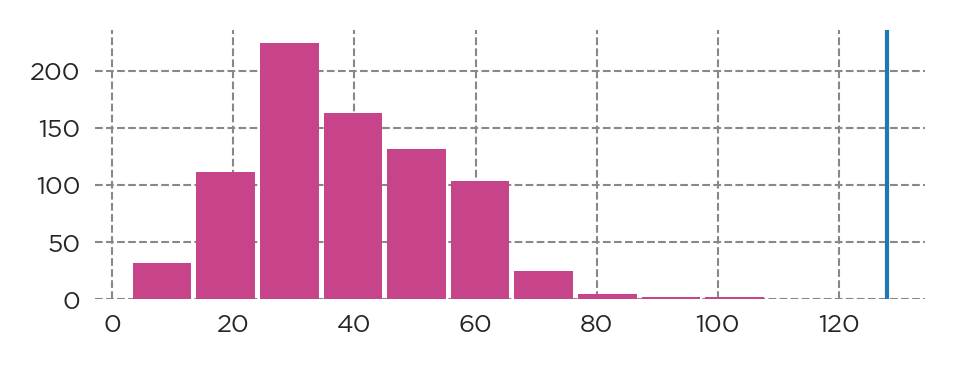

In [33]:
for num_flows, df in drops_per_ms.groupby('num_flows'):
    plt.figure()
    plorts.hist(df[df.num_dropped_flows > 0], x='num_dropped_flows')
    plt.axvline(x=num_flows)

In [7]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns

In [8]:
figsize=(width,width)
plt.figure(figsize=figsize)
i = 1

drops_per_n = []

drops_per_ms["frac_dropped"] = drops_per_ms.num_dropped_flows

for (alg,action,num_flows), df in drops_per_ms[drops_per_ms.num_dropped_flows > 0].groupby(['algorithm','action','num_flows']):
    drops = np.array(df["frac_dropped"])
    
    #res = bs.bootstrap(drops, stat_func=bs_stats.mean)

    drops_per_n.append([alg,action,num_flows, drops.min(), np.mean(drops), drops.max()])
drops_per_n = pd.DataFrame(drops_per_n, columns=['algorithm', 'action', "n", "min", "mean", "max"])
drops_per_n["predicted"] = np.sqrt(drops_per_n["n"])
drops_per_n

,algorithm,action,n,min,mean,max,predicted
0,bbr,drop,1,1,1.000000,1,1.000000
1,bbr,drop,2,1,1.994872,2,1.414214
2,bbr,drop,4,3,3.980198,5,2.000000
3,bbr,drop,8,6,7.910000,8,2.828427
4,bbr,drop,16,4,15.442786,16,4.000000
5,bbr,drop,32,19,25.378641,30,5.656854
6,bbr,drop,64,19,41.796020,56,8.000000
7,bbr,drop,128,43,58.085000,106,11.313708
8,cubic,drop,1,1,1.000000,1,1.000000
9,cubic,drop,2,1,1.750000,2,1.414214


<Figure size 257.076x257.076 with 0 Axes>

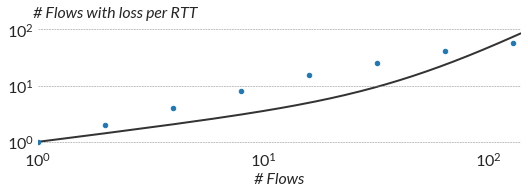

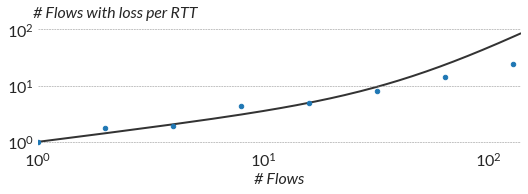

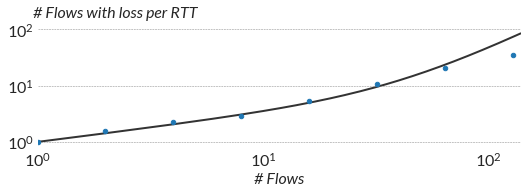

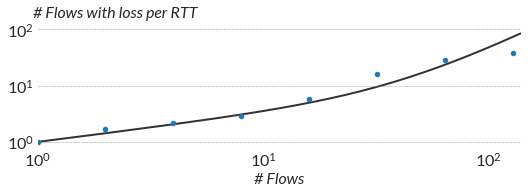

In [15]:
for (alg,action),df in drops_per_n.groupby(['algorithm', 'action']):
    plt.figure()
    xs = np.arange(1,128,0.01)    
    plt.plot([0,256], [0,0], linestyle=":", color='black')
    plt.axis(xmin=1,xmax=192)

    for i,(_,row) in enumerate(df.iterrows()):
        color = 'C{}'.format(i)
        offset = 0
        plt.scatter([row.n], [row['mean'] - offset], color='C0', s=20)
        #plt.plot([row.n, row.n], [row.lb - offset, row.ub - offset], color=color)
        
    ns = np.arange(0,140)
    #plt.plot(ns, np.sqrt(ns), label="sqrt(n)", zorder=0)
    #plt.plot(ns, 2*np.sqrt(ns), label="2*sqrt(n)", zorder=0)
    plt.plot(ns, np.sqrt(ns) + ns**2/(2*B), zorder=0, color='#333333')
    plt.rc('text', usetex=False)

    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    plt.axis(xmin=1,xmax=140)
    #plt.title("{} - {}".format(alg,action))
    plt.ylabel("# Flows with loss per RTT")
    plt.xlabel("# Flows")
    plorts.style_axis()
    plorts.savefig("../figures/{}_{}_flows_per_loss.png".format(alg,action))

In [ ]:
    plt.figure(figsize=(width, 1/3*width))

xs = np.arange(1,128,0.01)    
plt.plot([0,256], [0,0], linestyle=":", color='black')
plt.axis(xmin=1,xmax=192)

for i,(_,row) in enumerate(drops_per_n.iterrows()):
    color = 'C{}'.format(i)
    offset = 0
    plt.scatter([row.n], [row['mean'] - offset], color=color)
    #plt.scatter([row.n], [1/np.sqrt(row.n)], color=color, marker='s')
    plt.plot([row.n, row.n], [row.lb - offset, row.ub - offset], color=color)

#plt.plot(range(0, 128), range(0,128), label="")
plt.plot(range(0, 129), np.sqrt(np.arange(0,129)), label="sqrt(n)", zorder=0)
    
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
plt.ylabel("# Flows with Loss")
plt.xlabel("# Flows")
plt.axis(xmin=0, xmax=129)
plorts.style_axis()
plorts.savefig("../figures/flows_per_loss.png")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


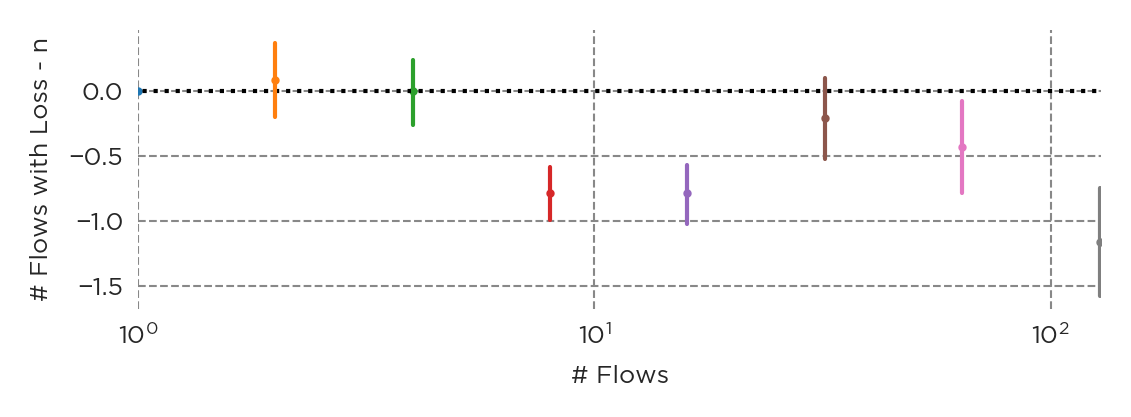

In [113]:
plt.figure(figsize=(width, 1/3*width))

xs = np.arange(1,128,0.01)    
plt.plot([0,256], [0,0], linestyle=":", color='black')
plt.axis(xmin=1,xmax=192)

for i,(_,row) in enumerate(drops_per_n.iterrows()):
    color = 'C{}'.format(i)
    offset = np.sqrt(row.n)
    plt.scatter([row.n], [row['mean'] - offset], color=color)
    #plt.scatter([row.n], [1/np.sqrt(row.n)], color=color, marker='s')
    plt.plot([row.n, row.n], [row.lb - offset, row.ub - offset], color=color)

#plt.plot(range(0, 128), range(0,128), label="")
#plt.plot(range(0, 129), np.sqrt(np.arange(0,129)), label="sqrt(n)", zorder=0)
    
#plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.ylabel("# Flows with Loss - n")
plt.xlabel("# Flows")
plt.axis(xmin=0, xmax=129)
#plorts.style_axis(show_xaxis=True)
plorts.savefig("../figures/flows_loss_error.png")

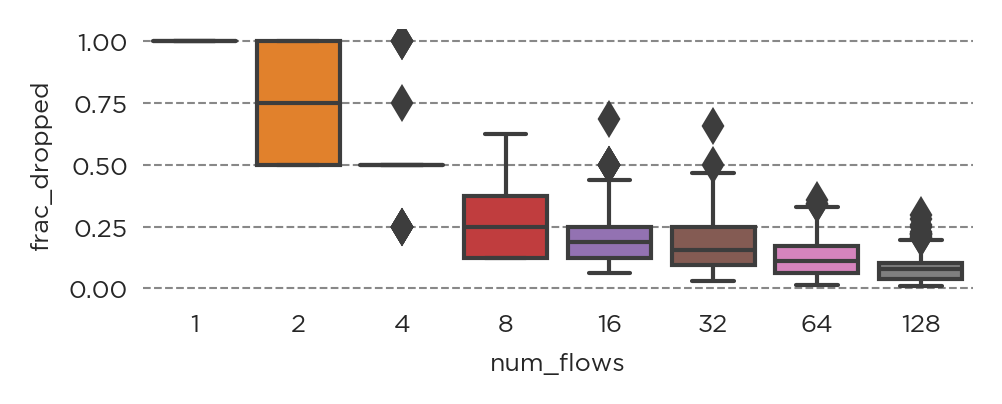

In [44]:
sns.boxplot(data=agg_df[agg_df.num_dropped_flows > 0], x="num_flows", y="frac_dropped")